<a href="https://colab.research.google.com/github/AkankshaK-AI/S5Assignment/blob/main/EVA7S5%40StepLR6_LR0_02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Adding image augmentation and LR tweaking

# Import Libraries

In [ ]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations



In [ ]:
# Train Phase transformations. Adding image rotation
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-7.0,7.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                      #  # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [ ]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


# Dataloader Arguments & Test/Train Dataloaders


In [ ]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


# Data Statistics



In [ ]:

# # We'd need to convert it into Numpy! Remember above we have converted it into tensors already
# train_data = train.train_data
# train_data = train.transform(train_data.numpy())

# print('[Train]')
# print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
# print(' - Tensor Shape:', train.train_data.size())
# print(' - min:', torch.min(train_data))
# print(' - max:', torch.max(train_data))
# print(' - mean:', torch.mean(train_data))
# print(' - std:', torch.std(train_data))
# print(' - var:', torch.var(train_data))

# dataiter = iter(train_loader)
# images, labels = dataiter.next()

# print(images.shape)
# print(labels.shape)

# # Let's visualize some of the images
# %matplotlib inline
# import matplotlib.pyplot as plt

# plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')


## MORE

It is important that we view as many images as possible. This is required to get some idea on image augmentation later on

In [ ]:
# figure = plt.figure()
# num_of_images = 60
# for index in range(1, num_of_images + 1):
#     plt.subplot(6, 10, index)
#     plt.axis('off')
#     plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

# Getting mean and std values for the transforms



In [ ]:

# simple_transforms = transforms.Compose([
#                                       #  transforms.Resize((28, 28)),
#                                       #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
#                                        transforms.ToTensor(),
#                                       #  transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
#                                        # Note the difference between (0.1307) and (0.1307,)
#                                        ])
# exp = datasets.MNIST('./data', train=True, download=True, transform=simple_transforms)
# exp_data = exp.train_data
# exp_data = exp.transform(exp_data.numpy())

# print('[Train]')
# print(' - Numpy Shape:', exp.train_data.cpu().numpy().shape)
# print(' - Tensor Shape:', exp.train_data.size())
# print(' - min:', torch.min(exp_data))
# print(' - max:', torch.max(exp_data))
# print(' - mean:', torch.mean(exp_data))
# print(' - std:', torch.std(exp_data))
# print(' - var:', torch.var(exp_data))

# The model
Increasing the number of parameters and correcting the Max pooling location

In [ ]:
dropout_value=0.1

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU(),
            nn.Dropout(dropout_value)
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=20, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(20),
            nn.ReLU(),
            nn.Dropout(dropout_value)
        ) # output_size = 24

        # Transition block 1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            # nn.BatchNorm2d(10),
            # nn.ReLU(),
            # nn.Dropout(dropout_value)
        ) # output_size = 24
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Dropout(dropout_value)
        ) # output_size = 10
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Dropout(dropout_value)
        ) # output_size = 8
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Dropout(dropout_value)
        ) # output_size = 6
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Dropout(dropout_value)
        ) # output_size = 6

        # OUTPUT BLOCK  
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        ) # output_size = 1
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1,1), padding=0, bias=False),
        ) # adding parameters after GAP layer



        self.dropout = nn.Dropout(dropout_value)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.gap(x)
        x = self.convblock8(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [ ]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
       BatchNorm2d-2           [-1, 10, 26, 26]              20
              ReLU-3           [-1, 10, 26, 26]               0
           Dropout-4           [-1, 10, 26, 26]               0
            Conv2d-5           [-1, 20, 24, 24]           1,800
       BatchNorm2d-6           [-1, 20, 24, 24]              40
              ReLU-7           [-1, 20, 24, 24]               0
           Dropout-8           [-1, 20, 24, 24]               0
            Conv2d-9           [-1, 10, 24, 24]             200
        MaxPool2d-10           [-1, 10, 12, 12]               0
           Conv2d-11           [-1, 16, 10, 10]           1,440
      BatchNorm2d-12           [-1, 16, 10, 10]              32
             ReLU-13           [-1, 16, 10, 10]               0
          Dropout-14           [-1

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


# Training and Testing



Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [ ]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = [] # train accuracy
test_acc = [] #test accuracy

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

# Let's Train and test our model

In [ ]:
from torch.optim.lr_scheduler import StepLR  # We have added Step LR here. We will be dropping the LR after every 6 epochs

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.02, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.1) #We will be dropping the LR by 0.1 after every 6 epochs


EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

EPOCH: 0


  0%|          | 0/469 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Loss=0.14037956297397614 Batch_id=468 Accuracy=85.99: 100%|██████████| 469/469 [00:26<00:00, 17.81it/s]



Test set: Average loss: 0.0915, Accuracy: 9742/10000 (97.42%)

EPOCH: 1


Loss=0.06008908152580261 Batch_id=468 Accuracy=97.47: 100%|██████████| 469/469 [00:26<00:00, 17.75it/s]



Test set: Average loss: 0.0391, Accuracy: 9895/10000 (98.95%)

EPOCH: 2


Loss=0.06641663610935211 Batch_id=468 Accuracy=98.01: 100%|██████████| 469/469 [00:26<00:00, 17.73it/s]



Test set: Average loss: 0.0329, Accuracy: 9906/10000 (99.06%)

EPOCH: 3


Loss=0.043191056698560715 Batch_id=468 Accuracy=98.25: 100%|██████████| 469/469 [00:26<00:00, 17.80it/s]



Test set: Average loss: 0.0383, Accuracy: 9888/10000 (98.88%)

EPOCH: 4


Loss=0.024439161643385887 Batch_id=468 Accuracy=98.38: 100%|██████████| 469/469 [00:26<00:00, 17.93it/s]



Test set: Average loss: 0.0376, Accuracy: 9889/10000 (98.89%)

EPOCH: 5


Loss=0.06350487470626831 Batch_id=468 Accuracy=98.51: 100%|██████████| 469/469 [00:26<00:00, 17.83it/s]



Test set: Average loss: 0.0326, Accuracy: 9894/10000 (98.94%)

EPOCH: 6


Loss=0.1420125514268875 Batch_id=468 Accuracy=98.65: 100%|██████████| 469/469 [00:26<00:00, 17.86it/s]



Test set: Average loss: 0.0271, Accuracy: 9925/10000 (99.25%)

EPOCH: 7


Loss=0.059458404779434204 Batch_id=468 Accuracy=98.58: 100%|██████████| 469/469 [00:26<00:00, 17.91it/s]



Test set: Average loss: 0.0352, Accuracy: 9876/10000 (98.76%)

EPOCH: 8


Loss=0.03728640452027321 Batch_id=468 Accuracy=98.77: 100%|██████████| 469/469 [00:26<00:00, 17.87it/s]



Test set: Average loss: 0.0221, Accuracy: 9930/10000 (99.30%)

EPOCH: 9


Loss=0.10981512814760208 Batch_id=468 Accuracy=98.77: 100%|██████████| 469/469 [00:26<00:00, 17.83it/s]



Test set: Average loss: 0.0235, Accuracy: 9925/10000 (99.25%)

EPOCH: 10


Loss=0.01624996028840542 Batch_id=468 Accuracy=98.81: 100%|██████████| 469/469 [00:26<00:00, 17.75it/s]



Test set: Average loss: 0.0259, Accuracy: 9917/10000 (99.17%)

EPOCH: 11


Loss=0.04326581582427025 Batch_id=468 Accuracy=98.80: 100%|██████████| 469/469 [00:26<00:00, 17.79it/s]



Test set: Average loss: 0.0229, Accuracy: 9934/10000 (99.34%)

EPOCH: 12


Loss=0.03172489255666733 Batch_id=468 Accuracy=98.86: 100%|██████████| 469/469 [00:26<00:00, 17.69it/s]



Test set: Average loss: 0.0255, Accuracy: 9919/10000 (99.19%)

EPOCH: 13


Loss=0.016391543671488762 Batch_id=468 Accuracy=98.90: 100%|██████████| 469/469 [00:26<00:00, 17.78it/s]



Test set: Average loss: 0.0242, Accuracy: 9925/10000 (99.25%)

EPOCH: 14


Loss=0.006556159351021051 Batch_id=468 Accuracy=98.84: 100%|██████████| 469/469 [00:26<00:00, 17.82it/s]



Test set: Average loss: 0.0186, Accuracy: 9946/10000 (99.46%)



Text(0.5, 1.0, 'Test Accuracy')

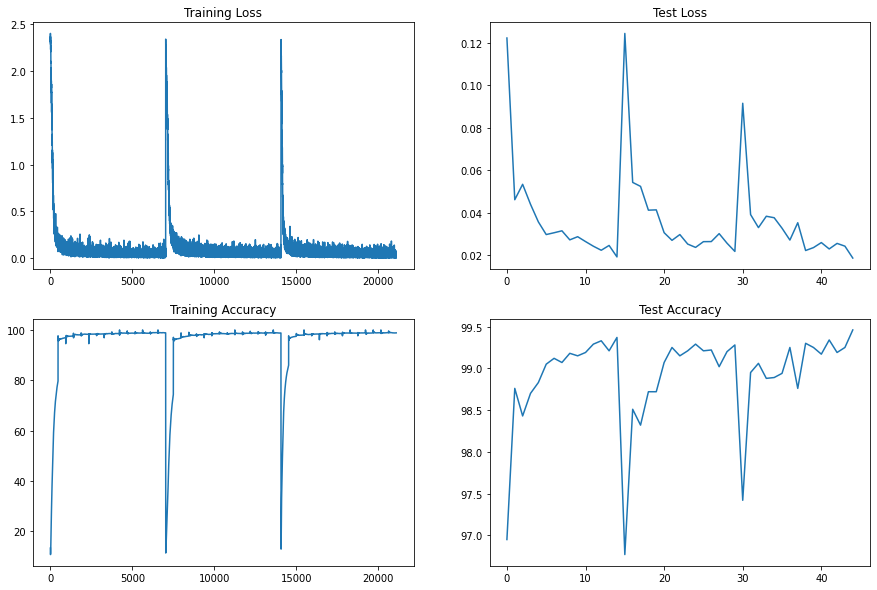

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")